In [1]:
import pandas as pd

df_pha = pd.read_csv('datasets/Psychosocial_Health_Analysis.csv')
df_pha['problem_category'] = df_pha['problem_category'].str.lower().str.strip()
df_pha['psychological_catehory'] = df_pha['psychological_catehory'].str.lower().str.strip()

df_pha = df_pha[
    (df_pha['problem_category'] == 'stress') | 
    (df_pha['problem_category'] == 'anxiety') |
    (df_pha['psychological_catehory'] == 'stress') |
    (df_pha['psychological_catehory'] == 'anxiety')
    ]

df_pha['label'] = 1
df_pha = df_pha.rename(columns={'Problem_description': 'text'})

df_pha = df_pha.drop(['Age', 'Gender', 'problem_summary', 'problem_category', 'psychological_catehory'], axis=1)

df_pha.head()

,text,label
0,A woman is sharing their challenges as the on...,1
3,"How to increase confidence? Feeling insecure, ...",1
5,"The user is in a complicated situation, caught...",1
6,The user was previously in a relationship but ...,1
8,The user is experiencing emotional turmoil due...,1


In [2]:
df_stress = pd.read_csv('datasets/Stress.csv')

df_stress = df_stress.drop(['subreddit','post_id','sentence_range','confidence','social_timestamp'], axis=1)

df_stress.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [3]:
df_mhc = pd.read_csv('datasets/NLP_Mental_Health_Conversations.csv')

df_mhc['label'] = 1
df_mhc = df_mhc.rename(columns={'Context': 'text'})

df_mhc = df_mhc.drop('Response', axis=1)
df_mhc = df_mhc.drop_duplicates()

df_mhc.head()

,text,label
0,I'm going through some things with my feelings...,1
23,I have so many issues to address. I have a his...,1
70,I have been feeling more and more down for ove...,1
72,I’m facing severe depression and anxiety and I...,1
81,How can I get to a place where I can be conten...,1


In [10]:
# Read in reddit posts from subreddits that are deemed positive. Note: Some datasets are too large, and are split into parts instead.
import re

filepaths = [
    ("datasets/reddit/MadeMeSmile_submissions00.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions01.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions02.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions03.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions04.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions05.zip", 90),
    ("datasets/reddit/wholesome_submissions.zip", 600)    
]

df_positive = pd.DataFrame(columns=['selftext'])

for f in filepaths:
    df_temp = pd.read_json(f[0], lines=True)[['selftext']]
    df_temp['selftext'] = df_temp['selftext'].apply(lambda x: re.sub(r'http\S+', '', x))
    df_temp = df_temp[
        (df_temp['selftext'] != '') & 
        (df_temp['selftext'] != '[deleted]') & 
        (df_temp['selftext'] != '[removed]') &
        (df_temp['selftext'].str.contains('removed by reddit', flags=re.IGNORECASE) == False) &
        (df_temp['selftext'].apply(lambda x: len(x.split()) >= 10))
    ].sample(f[1])

    df_positive = pd.concat([df_positive, df_temp], ignore_index=True)

df_positive = df_positive.reset_index(drop=True)

df_positive['label'] = 0
df_positive = df_positive.rename(columns={'selftext' : 'text'})

df_positive.head()

,text,label
0,Going through a tough time right now and spend...,0
1,My mom passed away almost two years ago. One t...,0
2,"So happy. Got my braces on November 12th, 2018...",0
3,Canadian air traffic controllers send pizzas t...,0
4,No special occasion. No birthday. No holiday. ...,0


In [11]:
# Combine all datasets into a single dataframe
df = pd.concat([df_pha, df_stress, df_mhc, df_positive], ignore_index=True)
df = df.reset_index(drop=True)

df.head()

,text,label
0,A woman is sharing their challenges as the on...,1
1,"How to increase confidence? Feeling insecure, ...",1
2,"The user is in a complicated situation, caught...",1
3,The user was previously in a relationship but ...,1
4,The user is experiencing emotional turmoil due...,1


In [12]:
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
# Clean up and lemmatize the texts.

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    

    return ' '.join(text)

df['processed_text'] = df['text'].apply(lambda x: process_texts(x))

df.sample(10)


,text,label,processed_text
2984,I am on my own with my daughter. I am so worri...,1,daughter worry stressed
3231,"I'm a teenager, and I just got my first job. I...",1,teenager get first job month half yesterday bo...
2413,Sometimes my voice catches for a minute and I ...,1,sometimes voice catch minute flush dark red fe...
2050,If its the wrong place for this feel free too ...,0,wrong place feel free delete would par rest da...
3774,"I'm a female freshman in high school, and this...",1,female freshman high school question male best...
2482,"Since then I have heard from him once, in the ...",1,since hear form drunken voicemail plead forgiv...
2327,Hey everybody! I'm conducting research on soci...,0,hey everybody conduct research social medium u...
3409,I have no sex drive due to medical issues. I’v...,1,sex drive due medical issue shut completely cl...
2013,She would be coming to the states for the firs...,0,would come state first time year dec ecstatic ...
1256,"If you would like to donate, please go to: <ur...",0,would like donate please go fundraising goal h...


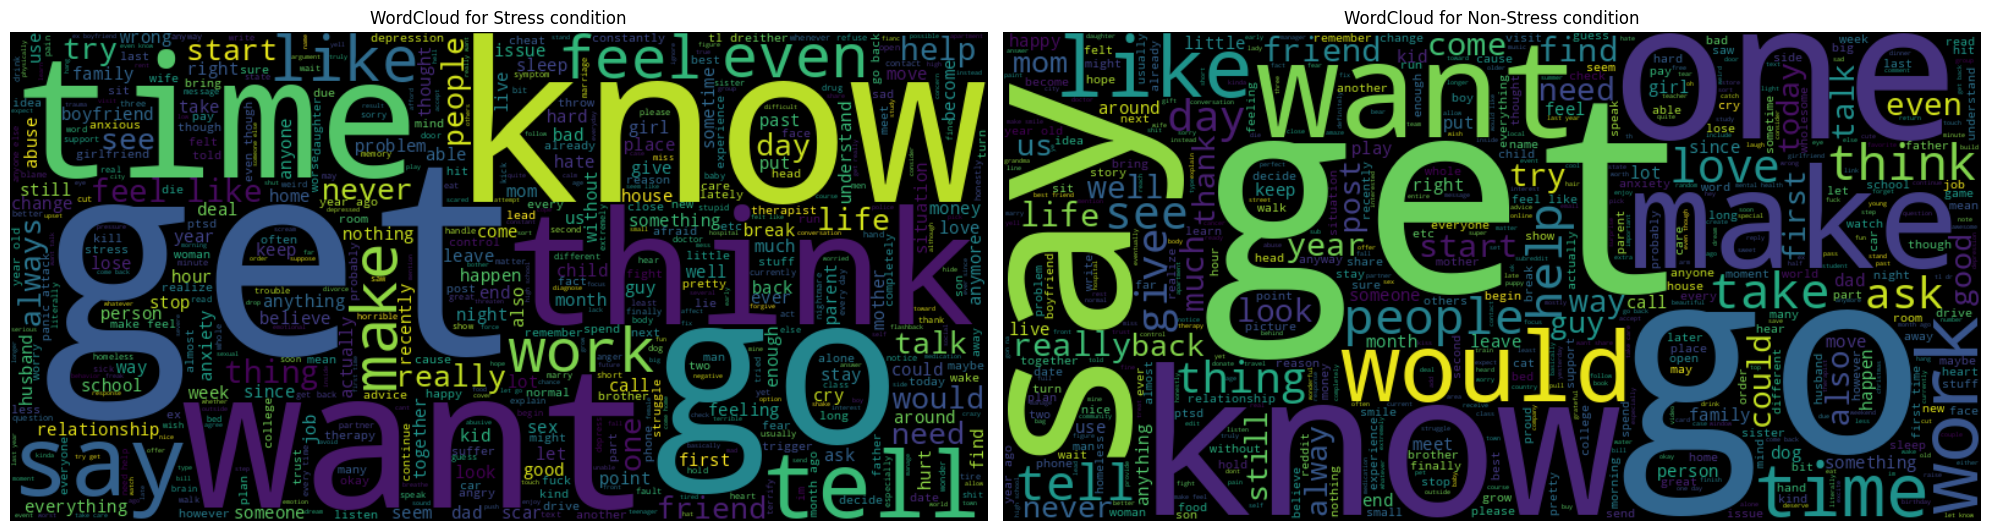

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

wc_stress = WordCloud(max_words=2000, width=800, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 1].processed_text))
axs[0].imshow(wc_stress, interpolation='bilinear')
axs[0].set_title('WordCloud for Stress condition')
axs[0].axis('off') 

wc_non_stress = WordCloud(max_words=2000, width=800, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 0].processed_text))
axs[1].imshow(wc_non_stress, interpolation='bilinear')
axs[1].set_title('WordCloud for Non-Stress condition')
axs[1].axis('off')  

plt.tight_layout()
plt.show()

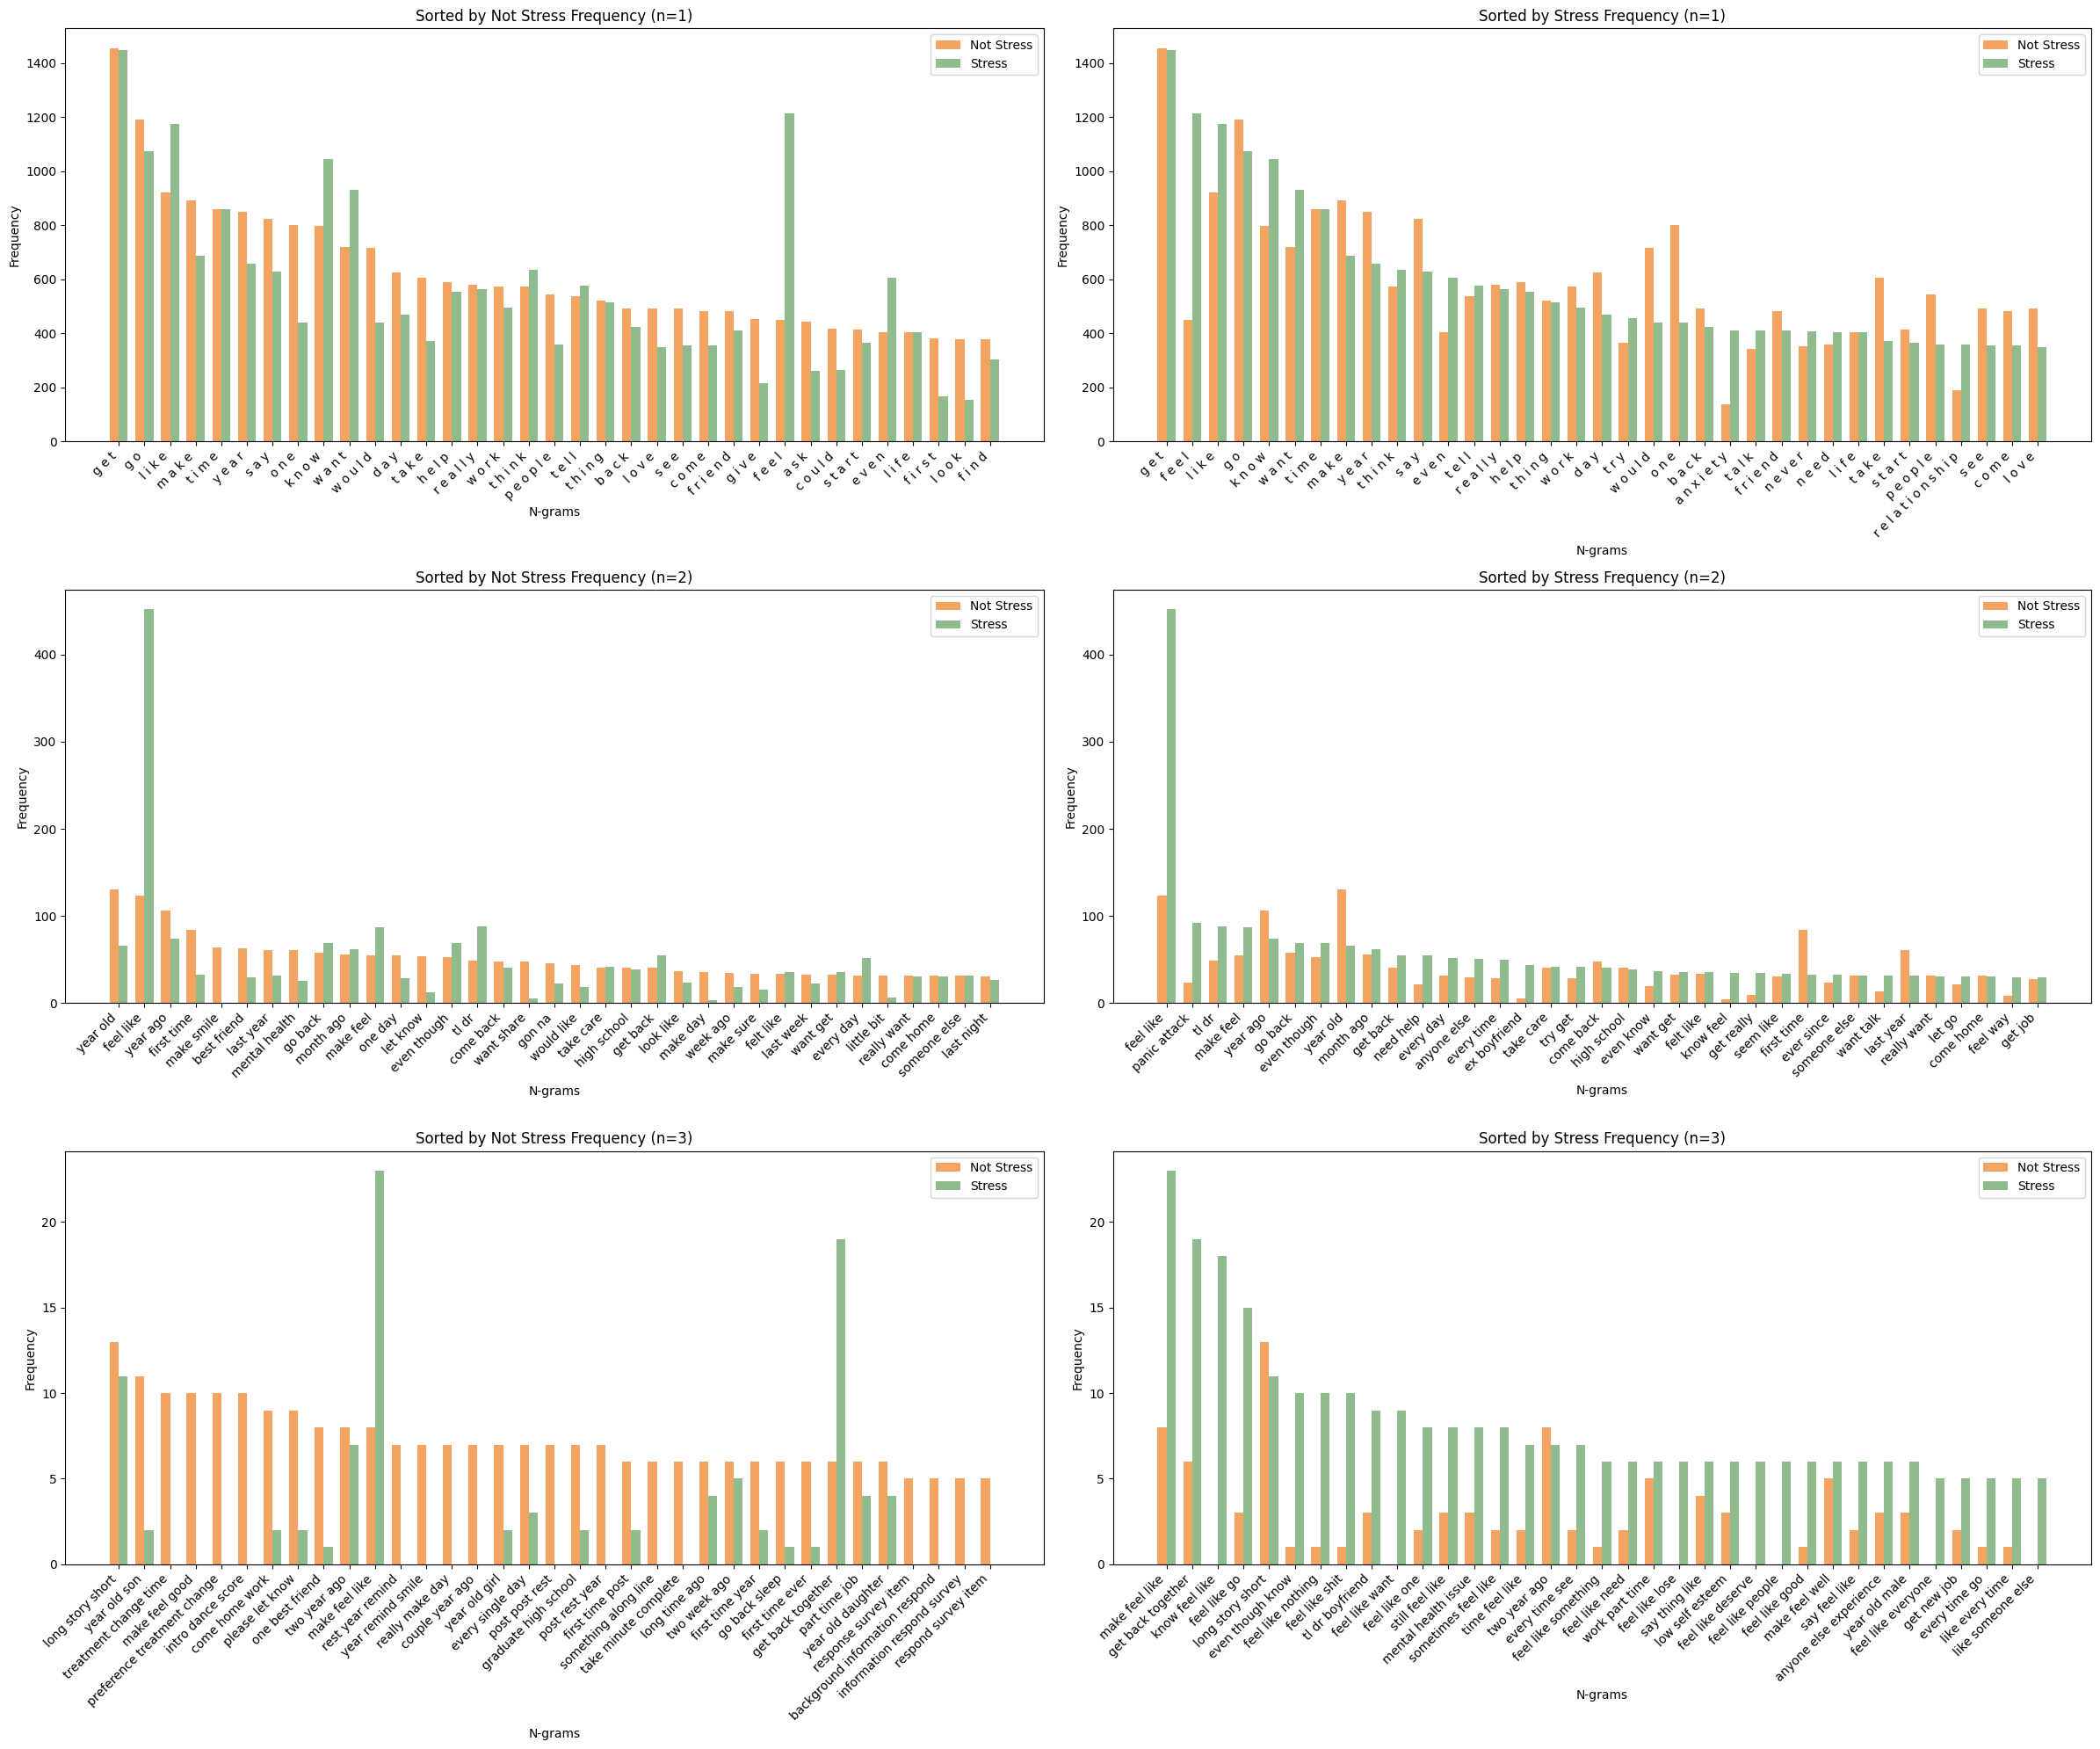

In [15]:
from nltk.util import bigrams, trigrams

# Helper function to get n-grams
def get_ngrams(text, n=1):
    tokens = word_tokenize(text.lower())
    if n == 1:
        return tokens  # Single words
    elif n == 2:
        return list(bigrams(tokens))
    elif n == 3:
        return list(trigrams(tokens))

# Generate and count n-grams frequencies
def count_ngrams(label, n=1):
    ngrams = df[df['label'] == label]['processed_text'].apply(get_ngrams, n=n).explode()
    return ngrams.value_counts().rename(f'label_{label}')

def plot_ngrams(ax, sorted_by_label_0, sorted_by_label_1, n=1):
    indices_0 = range(len(sorted_by_label_0))
    indices_1 = range(len(sorted_by_label_1))
    bar_width = 0.35

    ax[0].bar(indices_0, sorted_by_label_0[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[0].bar([i+bar_width for i in indices_0], sorted_by_label_0[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[0].set_title(f'Sorted by Not Stress Frequency (n={n})')
    ax[0].set_xticks([i + bar_width / 2 for i in indices_0])
    ax[0].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_0.index], rotation=45, ha="right")

    ax[1].bar(indices_1, sorted_by_label_1[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[1].bar([i+bar_width for i in indices_1], sorted_by_label_1[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[1].set_title(f'Sorted by Stress Frequency (n={n})')
    ax[1].set_xticks([i + bar_width / 2 for i in indices_1])
    ax[1].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_1.index], rotation=45, ha="right")

    for a in ax:
        a.set_xlabel('N-grams')
        a.set_ylabel('Frequency')
        a.legend()

# Setup the 2x3 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(24, 20))

# Single-word frequencies
freqs_0_words = count_ngrams(0, n=1)
freqs_1_words = count_ngrams(1, n=1)
sorted_by_label_0_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[0], sorted_by_label_0_words, sorted_by_label_1_words, n=1)

# Bigram frequencies
freqs_0_bigrams = count_ngrams(0, n=2)
freqs_1_bigrams = count_ngrams(1, n=2)
sorted_by_label_0_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[1], sorted_by_label_0_bigrams, sorted_by_label_1_bigrams, n=2)

# Trigram frequencies
freqs_0_trigrams = count_ngrams(0, n=3)
freqs_1_trigrams = count_ngrams(1, n=3)
sorted_by_label_0_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[2], sorted_by_label_0_trigrams, sorted_by_label_1_trigrams, n=3)

plt.tight_layout()
plt.show()